In [ ]:
import numpy as np
import scipy
import cv2
import matplotlib.pyplot as plt

# 1)

In [ ]:
def get_matches(img1, img2):
  orb = cv2.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  # Create a BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # Match descriptors
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  return matches, kp1, kp2

In [ ]:
def get_homography(pts1, pts2):
  pts1 = pts1.astype(np.float32)
  pts2 = pts2.astype(np.float32)

  num_pts = pts1.shape[0]
  A = np.zeros((num_pts * 2, 9))
  j = 0

  for i in range(num_pts):
    s = pts1[i]
    t = pts2[i]
    A[j]   = np.array([s[0], s[1], 1, 0, 0, 0, -t[0] * s[0], -t[0] * s[1], -t[0]])
    A[j+1] = np.array([0, 0, 0, s[0], s[1], 1, -t[1] * s[0], -t[1] * s[1], -t[1]])
    j += 2

  eigenValues, eigenVectors = np.linalg.eig(A.T @ A)

  idx = eigenValues.argsort()  
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]

  v = eigenVectors[:, 0]
  v = v.reshape((3,3))
  v = v / v[2,2]

  return v

In [ ]:
def get_keypoint_coord_from_match(matches, kp1, kp2, index):
  """ Gets the keypoint coordinates that correspond to matches[index].
      For example, if we want to get the coordinates of the keypoints corresponding
      to the 10th matching pair, we would be passing
      
              get_keypoint_coord_from_match(matches, kp1, kp2, 10)
      
      Then it will return keypoint1, keypoint2, where
      keypoint1: [x, y] coordinate of the keypoint in img1 that corresponds to matches[10]
      keypoint2: [x, y] coordinate of the keypoint in img2 that corresponds to matches[10]
  """

  keypoint1 = [kp1[matches[index].queryIdx].pt[0], kp1[matches[index].queryIdx].pt[1]]
  keypoint2 = [kp2[matches[index].trainIdx].pt[0], kp2[matches[index].trainIdx].pt[1]]
  return keypoint1, keypoint2


In [ ]:
def get_best_tranform(img1, img2):
  matches, kp1, kp2 = get_matches(img1, img2)

  # Some parameters
  num_samples = 4
  num_trials = 3000
  total_matches = len(matches)
  inlier_thresh = 25

  # To keep track of the best transformation
  xform = np.zeros((3, 3))
  most_inliers = 0

  # Loop through num_trials times
  for i in range(num_trials):

    # Randomly choose num_samples indices from total number of matches
    choices = np.random.choice(total_matches, num_samples, replace=False)

    # Get the matching keypoint coordinates from those indices
    pts1 = []
    pts2 = []

    for c in choices:
        p1, p2 = get_keypoint_coord_from_match(matches, kp1, kp2, c)
        pts1.append(p1)
        pts2.append(p2)

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    # Use getAffineTransform to get our transformation matrix
    transformation = get_homography(pts1, pts2)

    num_inliers = 0

    # Loop through all of our matches
    for j in range(total_matches):

      # Get the coordinates of the matching features using get_keypoint_coord_from_match
      p1, p2 = get_keypoint_coord_from_match(matches, kp1, kp2, j)

      # Compute the expected coordinate after transforming the keypoint from img1
      # using the computed affine transformation
      expect = transformation @ np.float32([p1[0], p1[1], 1])

      # If the distance between the expected coordinate and the actual coordinate in im2
      # is less than the inlier threshold, increment the number of inliers
      dist = np.sqrt((expect[0] - p2[0])**2 + (expect[1] - p2[1])**2)
      if dist < inlier_thresh:
        num_inliers = num_inliers + 1


    # If for this transformation we have found the most inliers update most_inliers and xform
    if num_inliers > most_inliers:
      most_inliers = num_inliers
      xform = np.copy(transformation)
  
  return xform

[[ 1.01579788e+00  8.36345901e-03  1.70211083e+01]
 [-8.97776400e-04  1.02132466e+00 -3.37916422e+01]
 [ 1.23124301e-05 -8.73025674e-06  1.00000000e+00]]


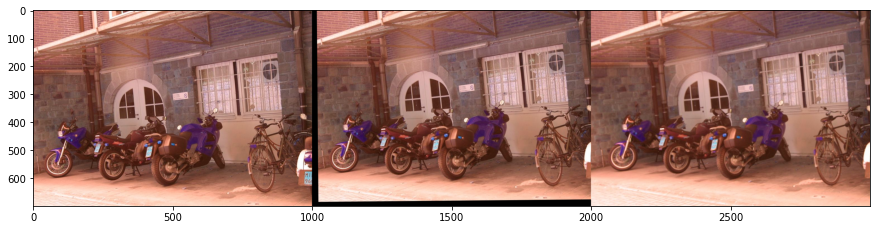

In [ ]:
img1 = cv2.imread("./data/bikes1.png")
img2 = cv2.imread("./data/bikes2.png")

xform = get_best_tranform(img1, img2)
rows, cols, channels = img1.shape
output = cv2.warpPerspective(img1, xform, (cols, rows))

fig = plt.figure(figsize=(15,15))
comp = cv2.hconcat([img1, output, img2])
plt.imshow(comp)
print(xform)

[[ 7.70764351e-01  2.46855104e-01 -3.44998464e+00]
 [-1.76355288e-01  8.76093236e-01  7.07542072e+01]
 [ 1.66317107e-04 -2.49914504e-04  1.00000000e+00]]


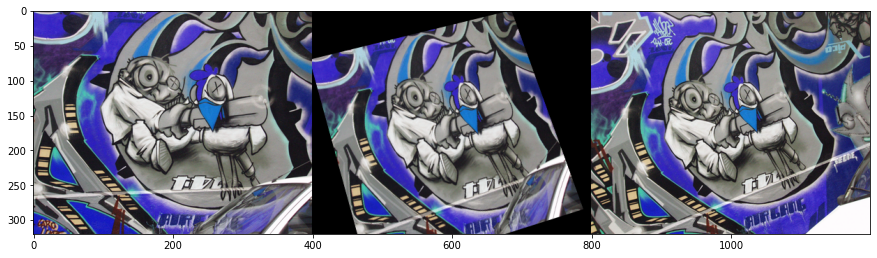

In [ ]:
img1 = cv2.imread("./data/graf1.png")
img2 = cv2.imread("./data/graf2.png")

xform = get_best_tranform(img1, img2)
rows, cols, channels = img1.shape
output = cv2.warpPerspective(img1, xform, (cols, rows))

fig = plt.figure(figsize=(15,15))
comp = cv2.hconcat([img1, output, img2])
plt.imshow(comp)
print(xform)

[[ 1.01213329e+00 -1.43863248e-02  4.32621842e+00]
 [ 3.07151355e-03  1.01018922e+00 -2.69435957e+00]
 [ 1.16362356e-05 -1.17774344e-05  1.00000000e+00]]


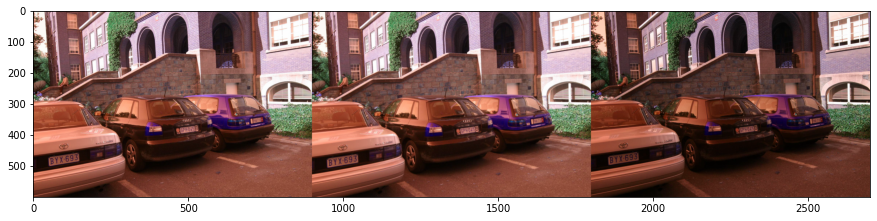

In [ ]:
img1 = cv2.imread("./data/leuven1.png")
img2 = cv2.imread("./data/leuven2.png")

xform = get_best_tranform(img1, img2)
rows, cols, channels = img1.shape
output = cv2.warpPerspective(img1, xform, (cols, rows))

fig = plt.figure(figsize=(15,15))
comp = cv2.hconcat([img1, output, img2])
plt.imshow(comp)
print(xform)

[[ 9.22498945e-01  4.39039645e-02  1.37153955e+01]
 [ 1.38509272e-02  1.04989047e+00  2.88291679e+01]
 [ 1.98361886e-05 -4.30809455e-05  1.00000000e+00]]


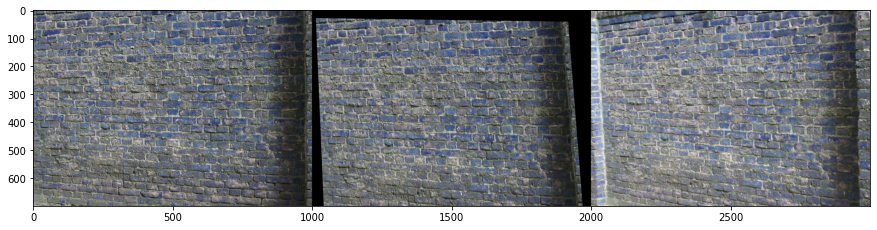

In [ ]:
img1 = cv2.imread("./data/wall1.png")
img2 = cv2.imread("./data/wall2.png")

img2 = cv2.resize(img2, (1000, 700))

xform = get_best_tranform(img1, img2)
rows, cols, channels = img1.shape
output = cv2.warpPerspective(img1, xform, (cols, rows))


fig = plt.figure(figsize=(15,15))
comp = cv2.hconcat([img1, output, img2])
plt.imshow(comp)
print(xform)

The results look good for the first 3 image pairs. The third pair seems to break the homography detector however.

# 2)

In [ ]:
def get_pixel_contributions(x, y):
  """ Gets the overlapped pixels along with the relative contributions.
      Args:
        x: The x-coordinate
        y: The y-coordinate
      Return:
        pixel_contributions: List of [x, y, contribution] where (x, y) are the coordinates of
                             pixels that the input overlaps with.
  """
  true_coord = np.array([x, y])
  int_coord = true_coord.astype(np.int)
  dec = true_coord - int_coord

  p0 = [int_coord[0], int_coord[1], (1 - dec[0])*(1 - dec[1])]
  p1 = [int_coord[0], int_coord[1] + 1, (1 - dec[0])*(dec[1])]
  p2 = [int_coord[0] + 1, int_coord[1], (dec[0])*(1 - dec[1])]
  p3 = [int_coord[0] + 1, int_coord[1] + 1, (dec[0])*(dec[1])]

  pixel_contributions = [p0, p1, p2, p3]


  return pixel_contributions




def inverse_warping(transform, image, dims):
  cols, rows = dims

  output_image = np.zeros((rows, cols, 3), dtype=int)

  # Invert the transformation matrix
  transform = np.linalg.inv(transform)


  for i in range(rows):
    for j in range(cols):

      # Get the resulting pixel coordinate after applying the inverse transformation above for pixel (j, i()
      result = transform @ np.array([[j], [i], [1]])

      # Use interpolation 
      interpolations = get_pixel_contributions(result[0, 0], result[1, 0])

      # Do something similar to forward_warping but with inverse warping
      for k in range(4):
        x = interpolations[k][0]
        y = interpolations[k][1]
        scale = interpolations[k][2]
        if -1 < x < cols and -1 < y < rows:
          output_image[i, j, 0] += int(scale * image[y, x, 0])
          output_image[i, j, 1] += int(scale * image[y, x, 1])
          output_image[i, j, 2] += int(scale * image[y, x, 2])


  return output_image

In [ ]:
def get_mosaic(images):
  l = len(images)

  if l % 2 == 0:
    return 

  mid = int((l+1)/2) - 1
  
  transforms = []
  transformed_images = []
  rows, cols, channels = images[mid].shape

  for i in range(l):
    if i == mid:
      transformed_images.append(images[mid])
      continue

    img = images[i]
    xform = get_best_tranform(img, images[mid])
    output = inverse_warping(xform, img, (cols, rows))

    transforms.append(xform)
    transformed_images.append(output.astype(np.uint8))

  mosaic = transformed_images[0]
  for i in range(1, l):
    mosaic = cv2.addWeighted(mosaic, i/(i+1), transformed_images[i], 1/(i+1), 0)

  transforms = np.array(transforms)

  return transforms, mosaic

[[[ 9.96452147e-01  3.64878177e-02  7.31681704e+00]
  [-1.85416656e-02  1.00380887e+00 -2.16063286e+01]
  [-3.15934909e-05  2.01120000e-05  1.00000000e+00]]

 [[ 9.98399001e-01 -9.81391914e-03  3.04641808e+01]
  [-3.66910975e-03  1.05366991e+00 -8.81061873e+00]
  [-1.48753647e-05  6.26268600e-05  1.00000000e+00]]]


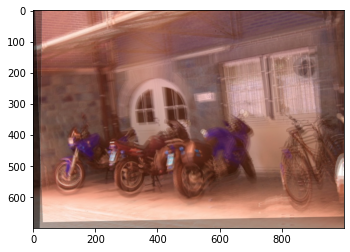

In [ ]:
img1 = cv2.imread('./data/bikes1.png')
img2 = cv2.imread('./data/bikes2.png')
img3 = cv2.imread('./data/bikes3.png')

imgs = [img1, img2, img3]

transforms, mosaic = get_mosaic(imgs)

plt.imshow(mosaic)
print(transforms)

[[[ 8.05649638e-01  2.13610160e-01 -7.14811870e-01]
  [-1.99033991e-01  7.99489848e-01  9.12168419e+01]
  [ 2.87690724e-04 -3.08284858e-04  1.00000000e+00]]

 [[ 1.23424490e+00 -4.79923634e-01  3.41469762e+01]
  [ 1.76818346e-02  1.12250035e+00 -1.45639538e+01]
  [-4.41510322e-04  5.80554274e-04  1.00000000e+00]]]


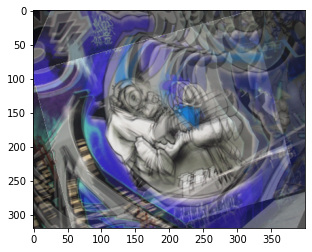

In [ ]:
img1 = cv2.imread('./data/graf1.png')
img2 = cv2.imread('./data/graf2.png')
img3 = cv2.imread('./data/graf3.png')

imgs = [img1, img2, img3]

transforms, mosaic = get_mosaic(imgs)

plt.imshow(mosaic)
print(transforms)

[[ 9.27614934e-01  1.86914063e-02  1.08143682e+01]
 [ 4.93654230e-02  1.01139270e+00  1.08733402e+01]
 [ 1.74072180e-05 -7.03886040e-05  1.00000000e+00]]


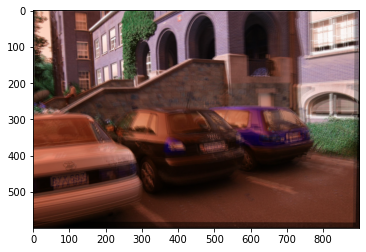

In [ ]:
img1 = cv2.imread('./data/leuven1.png')
img2 = cv2.imread('./data/leuven2.png')
img3 = cv2.imread('./data/leuven3.png')

imgs = [img1, img2, img3]


transforms, mosaic = get_mosaic(imgs)

plt.imshow(mosaic)
print(xform)

[[[ 9.27209930e-01  5.20983313e-03  2.22192327e+01]
  [ 1.26551380e-02  1.05535698e+00  2.40066273e+01]
  [ 1.66164922e-05 -1.63833811e-05  1.00000000e+00]]

 [[-8.22181471e-01  5.61719551e-01  5.13745823e+02]
  [-6.32032844e-01  3.75044279e-01  3.86489956e+02]
  [-1.58606390e-03  9.32143590e-04  1.00000000e+00]]]


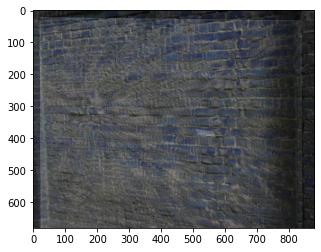

In [ ]:
img1 = cv2.imread('./data/wall1.png')
img2 = cv2.imread('./data/wall2.png')
img3 = cv2.imread('./data/wall3.png')

img1 = cv2.resize(img1, (880, 680))

imgs = [img1, img2, img3]

transforms, mosaic = get_mosaic(imgs)

plt.imshow(mosaic)
print(transforms)

### 3)

### Note: The algorithm works most of the time, BUT you may need to run it a couple times to get a good result! Also, the test images must have robust features. So the algorithm is not able to detect the wall image.

In [ ]:
# make an orb detector (it will be reused)
orb = cv2.ORB_create()
# Create a BFMatcher object (it will be reused)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)


def get_features(imgs):
  # create a dictionary indexed by file name and with contains key points and 
  # descriptor matrices
  features = {}

  for img in imgs:
    name = img.replace('.png', '').replace('./', '').replace('data/', '')
    img = cv2.imread(img)
    kp, des = orb.detectAndCompute(img,None)

    features[name] = (kp, des, img)
  
  return features


def get_best_matches(des1, des2):
  # Match descriptors
  matches = bf.match(des1,des2)

  # Sort them in the order of their distance.
  matches = sorted(matches, key = lambda x:x.distance)

  return matches[:50]


def mask_search_image(temp, search):

  mask = temp.astype(np.int)
  mask[mask==0]=-1
  mask[mask!=-1]=0
  mask[mask==-1]=255
  mask = mask.astype(np.uint8)

  return cv2.bitwise_and(search, mask)


def get_bounding_box(img, xform):
  r, c , _ = img.shape

  # get the corner points of the template image
  p1 = (xform @ np.array([0, 0, 1]))
  p2 = (xform @ np.array([c, 0, 1]))
  p3 = (xform @ np.array([c, r, 1]))
  p4 = (xform @ np.array([0, r, 1]))

  
  #transform the corners to the location in the search image
  p1 = np.round(p1 / p1[2]).astype(np.int)[:2]
  p2 = np.round(p2 / p2[2]).astype(np.int)[:2]
  p3 = np.round(p3 / p3[2]).astype(np.int)[:2]
  p4 = np.round(p4 / p4[2]).astype(np.int)[:2]

  return np.array([p1, p2, p3, p4], np.int32)

In [ ]:
def ransac(matches, kp1, kp2):
  # first 10 matches gauranteed to be best. Use these to generate transform
  # there are only 10 choose 4 = 210 ways to get a homography
  num_samples = 4
  num_trials = 200
  total_matches = 20   
  inlier_thresh = 25

  # To keep track of the best transformation
  xform = np.zeros((3, 3))
  most_inliers = 0

  # Loop through num_trials times
  for i in range(num_trials):

    # Randomly choose num_samples indices from total number of matches
    choices = np.random.choice(10, num_samples, replace=False)

    # Get the matching keypoint coordinates from those indices
    pts1 = []
    pts2 = []

    for c in choices:
        p1, p2 = get_keypoint_coord_from_match(matches, kp1, kp2, c)
        pts1.append(p1)
        pts2.append(p2)

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)

    # Use getAffineTransform to get our transformation matrix
    transformation = get_homography(pts1, pts2)

    num_inliers = 0

    # Loop through all of our matches (including new ones) to determine
    # best transform
    for j in range(len(matches)):

      # Get the coordinates of the matching features using get_keypoint_coord_from_match
      p1, p2 = get_keypoint_coord_from_match(matches, kp1, kp2, j)

      # Compute the expected coordinate after transforming the keypoint from img1
      # using the computed affine transformation
      expect = transformation @ np.float32([p1[0], p1[1], 1])

      # If the distance between the expected coordinate and the actual coordinate in im2
      # is less than the inlier threshold, increment the number of inliers
      dist = np.sqrt((expect[0] - p2[0])**2 + (expect[1] - p2[1])**2)
      if dist < inlier_thresh:
        num_inliers = num_inliers + 1


    # If for this transformation we have found the most inliers update most_inliers and xform
    if num_inliers > most_inliers:
      most_inliers = num_inliers
      xform = np.copy(transformation)
  
  return xform, most_inliers

In [ ]:
def detect_images(imgs, search_img):
  # get rows and colums for transform
  rows, cols, channels = search_img.shape
  # make copy for bounding box
  bound = search_img.copy()

  # get features of template images
  img_feats = get_features(imgs)

  detected_images = []
  
  # keep on searching until can't find any more images
  while True:
    kp_search, des_search = orb.detectAndCompute(search_img, None)

    # find the template image that best fits the search image
    max_score = 5
    best_image = -1
    best_xform = -1

    for temp in img_feats.keys():
      kp, des, _ = img_feats[temp]
      matches = get_best_matches(des, des_search)
      xform, score = ransac(matches, kp, kp_search)

      # only want the image with the best match
      if score > max_score:
        max_score = score
        best_image = temp
        best_xform = xform

    # ransac was able to find a good image match
    if best_image != -1:
      _, _, img = img_feats[best_image]
      output = cv2.warpPerspective(img, best_xform, (cols, rows))

      box = get_bounding_box(img, best_xform)
      detected_images.append((best_image, box))

      search_img = mask_search_image(output, search_img)

    # no good image matches
    else:
      break
  
  for _, box in detected_images:
    pts = box.reshape((-1,1,2))
    bound = cv2.polylines(bound,[box],True,(255,0,0), 10)
  
  return detected_images, bound

[('leuven1', array([[1352,   -7],
       [2650,   -6],
       [2646,  852],
       [1379,  840]], dtype=int32)), ('bikes1', array([[2362,  222],
       [3372,  995],
       [2846, 1713],
       [1813,  928]], dtype=int32)), ('leuven1', array([[1147,  113],
       [2643, 1260],
       [1866, 2233],
       [ 398, 1110]], dtype=int32))]


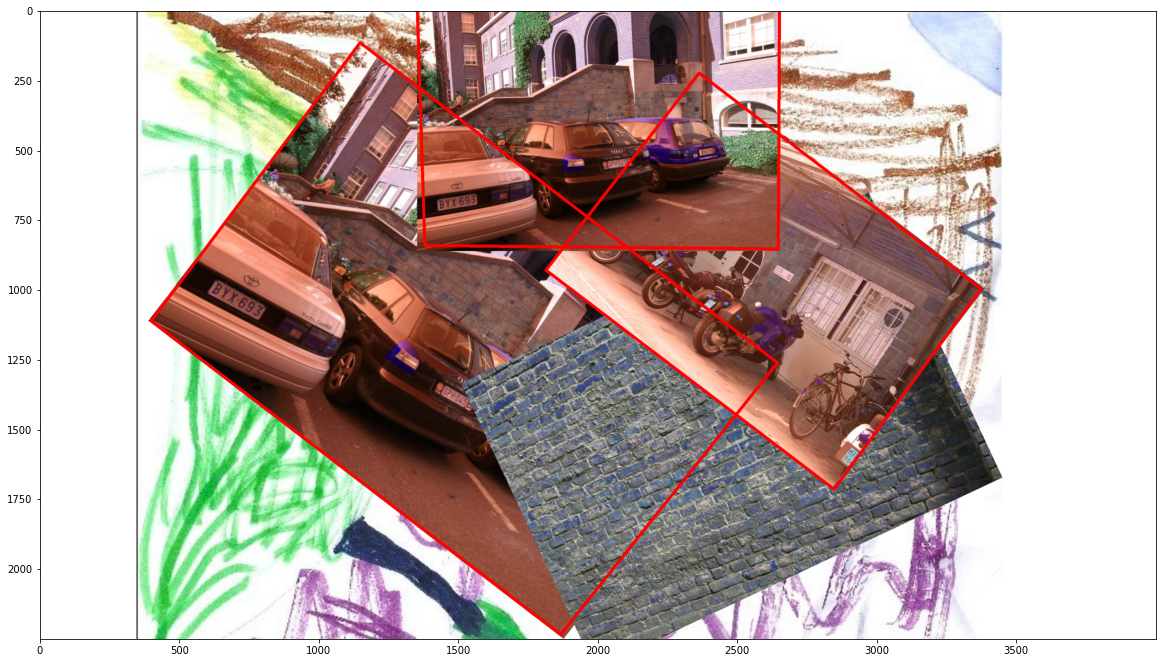

In [ ]:
# specify images to be used
imgs = ['./data/bikes1.png', './data/graf1.png', './data/leuven1.png', './data/wall1.png']
search_img = cv2.imread('./data/testexample.jpg')


objs, bound = detect_images(imgs, search_img)
print(objs)

fig = plt.figure(figsize=(20,20))
plt.imshow(bound)